In [1]:
import pickle
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score

from prettytable import PrettyTable

from collections import Counter

from matplotlib import pyplot as plt

from captum.attr import IntegratedGradients

In [2]:
with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)


# print(len(data))
# print(train_data[0][0])
# print(test_data[0][0])
print(data[0][0])



[ 0.51851852  0.72        0.21428571  0.43137255  0.25        0.7
  9.          2.         12.          0.47353246  0.46016297  0.44980291
  0.43589744  7.        ]
14


In [97]:
text_features = []
for d in data:
    text_features.append(d[0])

text_features = np.asarray(text_features)

In [102]:
complexity_df = pd.DataFrame(text_features[:,[6,8,13]])
complexity_df.describe()

,0,1,2
count,6624.000000,6624.000000,6624.000000
mean,8.560934,12.625000,8.375000
std,0.947731,1.727665,1.943351
min,7.181818,11.000000,6.000000
25%,8.000000,11.000000,7.000000
50%,8.235294,12.000000,8.000000
75%,9.000000,14.000000,10.000000
max,10.333333,16.000000,13.000000


In [105]:
complexity_df[0]

0       9.000000
1       9.000000
2       9.000000
3       9.000000
4       9.000000
          ...   
6619    7.181818
6620    7.181818
6621    7.181818
6622    7.181818
6623    7.181818
Name: 0, Length: 6624, dtype: float64

In [108]:
from scipy.stats.stats import pearsonr
pearsonr(complexity_df[1],complexity_df[2])

(0.11015698339985248, 2.446935797385076e-19)

In [3]:
feature_names = ['Vocabulary Knowledge', #0
                 'Phonological Awareness', #1
                 'Syntax Awareness', #2
                 'Working Memory', #3
                 'Word Reading Fluency', #4
                 'Word Reading Accuracy', #5
                 'Sentence Complexity ($\it{M}$)', #6
                 'Sentence Complexity ($\it{SD}$)', #7
                 'Sentence Complexity ($\it{max}$)', #8
                 'Lexical Surprisal ($\it{M}$)', #9
                 'Lexical Surprisal ($\it{SD}$)', #10
                 'Lexical Surprisal ($\it{max}$)', #11
                 'Rare Word Use', #12
                 'Question Complexity', # 13
                ]
print(len(feature_names))

14


In [4]:
def create_tensors(data_list):
    # create tensor that is compatible to load and train in the language model
    ds = {}
    keys = ['skills','subtests','questions','y','p_index']
    for key in keys:
        ds[key] = []
    
    for entry in data_list:
        ds['skills'].append(entry[0])
        ds['subtests'].append(entry[1])
        ds['questions'].append(entry[2])
        ds['y'].append(entry[3])
        ds['p_index'].append(entry[4])
    
    ds['skills'] = torch.tensor(ds['skills']).type(torch.float)
    ds['subtests'] = torch.tensor(ds['subtests'])
    ds['questions'] = torch.tensor(ds['questions'])
    ds['y'] = torch.tensor(ds['y']).type(torch.float)

    return ds

In [224]:
class BertModel1(nn.Module):
    def __init__(self, sentence_dim, skill_dim, dropout):
        super().__init__()
        self.skill_dim = skill_dim
        self.fc_test = nn.Linear(768,sentence_dim)
        self.fc_question = nn.Linear(768,sentence_dim)
        self.fc_answer = nn.Linear(768,sentence_dim)
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(2*sentence_dim+skill_dim*2,128)
#         self.fc2 = nn.Linear(sentence_dim+skill_dim*2,128)
        self.out = nn.Linear(128,1)
    
    def forward(self, skills,test,question):
        # x1 = self.fc_skill(skills[:,:self.skill_dim])
        x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,6]])
        x2 = self.fc_test(test)
        x3 = self.fc_question(question)
        x = torch.cat((x1,x2,x3),dim=1)
#         x = torch.cat((x1,x2),dim=1)
        x = self.fc2(self.relu(x))
        pred = self.out(self.relu(x))
        
        return pred

class BertModel2(nn.Module):
    def __init__(self, sentence_dim, skill_dim, dropout):
        super().__init__()
        self.skill_dim = skill_dim
        self.fc_test = nn.Linear(768,sentence_dim)
        self.fc_question = nn.Linear(768,sentence_dim)
        self.fc_answer = nn.Linear(768,sentence_dim)
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(2*sentence_dim+skill_dim*2,128)
#         self.fc2 = nn.Linear(sentence_dim+skill_dim*2,128)
        self.out = nn.Linear(128,1)
    
    def forward(self, skills,test,question):
        # x1 = self.fc_skill(skills[:,:self.skill_dim])
        x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,8]])
        x2 = self.fc_test(test)
        x3 = self.fc_question(question)
        x = torch.cat((x1,x2,x3),dim=1)
#         x = torch.cat((x1,x2),dim=1)
        x = self.fc2(self.relu(x))
        pred = self.out(self.relu(x))
        
        return pred

In [6]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [7]:
def confusion_matrix(preds, Y):
    rounded_preds = torch.round(preds.sigmoid())
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i, value in enumerate(rounded_preds):
        if value == Y[i] and value == 1:
            TP += 1
        elif value == Y[i] and value == 0:
            TN += 1
        elif value != Y[i] and value == 0:
            FN += 1
        elif value != Y[i] and value == 1:
            FP += 1
        else:
            print(value,Y[i])
    print(f'TP: {TP}\tFN: {FN}')
    print(f'FP: {FP}\tTN: {TN}')

In [8]:

def precision(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
#     print((rounded_preds==1).sum())
#     print((y==1).sum())
    return precision_score(y,rounded_preds)

def recall(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
    return recall_score(y,rounded_preds)
    

In [9]:
def train(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills'],data['subtests'],data['questions']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 


In [10]:
def evaluate(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():
        
        predictions = model(data['skills'],data['subtests'],data['questions']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        if matrix:
            confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [222]:
max_epochs = 300
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 64
skill_dim = 7
dropout = 0.1
verbose = False

model_results = []


for i in range(10):
    print(f"Run {i}")
    # Get training and testing data
    train_data, test_data = train_test_split(data, test_size=0.2, random_state = i)
    
    # fix layer initialization
    torch.manual_seed(10)
    net = BertModel2(sentence_dim, skill_dim, dropout)
    criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
    train_ds = create_tensors(train_data)
    test_ds = create_tensors(test_data)

    max_stats = [0,0,0,0,0] # each position represents acc, prec, recall, f1, epoch number respectively
    for epoch in range(max_epochs):
        train_loss, train_acc = train(net,train_ds,optimizer,criterion)

        if epoch % ep_log_interval == 0:
            
            valid_loss, valid_acc, prec, rec = evaluate(net,test_ds,criterion,matrix=False)
            if verbose:
                print(f'Epoch: {epoch}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
                print('precision: ', prec)
                print('recall: ', rec)
                try:
                    f1 = 2*(prec*rec)/(prec+rec)
                    print(f"f1 = {f1}")
                except:
                    continue
            if valid_acc > max_stats[0]:
                max_stats[0] = float(valid_acc)
                max_stats[1] = prec
                max_stats[2] = rec
                max_stats[4] = epoch
                torch.save(net.state_dict(), 'context_max.pt')#sc_c.pt
                # sentence_embedding_model
                
    print(max_stats)        
    model_results.append(max_stats)

print(model_results)

Run 0
[0.698867917060852, 0.7083888149134487, 0.7471910112359551, 0, 275]
Run 1
[0.6784905791282654, 0.6828644501278772, 0.75, 0, 275]
Run 2
[0.6966037750244141, 0.7282463186077643, 0.7321668909825033, 0, 150]
Run 3
[0.702641487121582, 0.7182539682539683, 0.75, 0, 150]
Run 4
[0.6867924332618713, 0.6945551128818062, 0.7387005649717514, 0, 150]
Run 5
[0.704150915145874, 0.7227101631116688, 0.7710843373493976, 0, 200]
Run 6
[0.6913207769393921, 0.6987341772151898, 0.7634854771784232, 0, 275]
Run 7
[0.704150915145874, 0.7406417112299465, 0.7367021276595744, 0, 150]
Run 8
[0.6958490610122681, 0.7070967741935484, 0.7569060773480663, 0, 275]
Run 9
[0.7124528288841248, 0.71712158808933, 0.7906976744186046, 0, 275]
[[0.698867917060852, 0.7083888149134487, 0.7471910112359551, 0, 275], [0.6784905791282654, 0.6828644501278772, 0.75, 0, 275], [0.6966037750244141, 0.7282463186077643, 0.7321668909825033, 0, 150], [0.702641487121582, 0.7182539682539683, 0.75, 0, 150], [0.6867924332618713, 0.6945551128

In [221]:
new_result = np.asarray(model_results)
print(new_result.shape)
print("mean",np.mean(new_result,axis=0))
print("std",np.std(new_result,axis=0))

(10, 5)
mean [  0.69969811   0.71452217   0.75500151   0.         207.5       ]
std [9.46530046e-03 1.57386396e-02 1.52098574e-02 0.00000000e+00
 4.03887361e+01]


In [223]:
new_result = np.asarray(model_results)
print(new_result.shape)
print("mean",np.mean(new_result,axis=0))
print("std",np.std(new_result,axis=0))

(10, 5)
mean [  0.69713207   0.71186131   0.75369342   0.         217.5       ]
std [9.25597360e-03 1.62185610e-02 1.68059799e-02 0.00000000e+00
 5.92135964e+01]


In [240]:
model_1 = BertModel2(64, 7, 0.1)
model_1.load_state_dict(torch.load('context_max.pt'))
print(model_1)

train_data, test_data = train_test_split(data, test_size=0.2, random_state = 40)
test_ds = create_tensors(test_data)

criterion = nn.BCEWithLogitsLoss()
evaluate(model_1,test_ds,criterion,matrix=False)

BertModel2(
  (fc_test): Linear(in_features=768, out_features=64, bias=True)
  (fc_question): Linear(in_features=768, out_features=64, bias=True)
  (fc_answer): Linear(in_features=768, out_features=64, bias=True)
  (fc_skill): Linear(in_features=7, out_features=14, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=142, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


(tensor(0.5799), tensor(0.6891), 0.6833976833976834, 0.7618364418938307)

In [241]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(model_1)
test_ds['skills'].requires_grad_()
test_ds['subtests'].requires_grad_()
test_ds['questions'].requires_grad_()



attr,delta = ig.attribute((test_ds['skills'],test_ds['subtests'],test_ds['questions'])\
                          ,return_convergence_delta=True)
attr = attr[0].detach().numpy()
print(attr)

[[ 0.13852567 -0.47148597  1.20681279 ...  0.          0.
   0.        ]
 [ 0.09920105 -0.35378106  0.99046591 ...  0.          0.
   0.        ]
 [ 0.09567623 -0.45963691  1.1336993  ...  0.          0.
   0.        ]
 ...
 [ 0.05704688 -0.39773935  1.0538151  ...  0.          0.
   0.        ]
 [ 0.15122236 -0.37354295  1.32120496 ...  0.          0.
   0.        ]
 [ 0.04762553 -0.1501772   0.73866172 ...  0.          0.
   0.        ]]


In [238]:
%matplotlib qt 
# attr = attr[0].detach().numpy()
from matplotlib import pyplot as plt

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    new_feature_names = []
    new_importances = []
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
        if importances[i] == 0:
            continue
        else:
            new_feature_names.append(feature_names[i])
            new_importances.append(importances[i])
    x_pos = (np.arange(len(new_feature_names)))
    # temp = importances[6]
    # new_importances[6] = importances[8]
    # new_importances[8] = temp

    if plot:
        plt.figure(figsize=(12,8))
        plt.bar(x_pos, new_importances, align='center', color='#DBDBA7')
        plt.xticks(x_pos, new_feature_names, rotation=45, ha="right", fontsize=19)
        plt.yticks(fontsize=20)
        
        plt.xlabel(axis_title,fontsize=20)
        plt.ylabel('Integrated Gradient',fontsize=20)
        plt.ylim(-4.5,4.5)
        plt.tight_layout()

#         plt.title(title)
#     plt.show()


In [242]:
visualize_importances(feature_names, np.mean(attr, axis=0))

Vocabulary Knowledge :  0.085
Phonological Awareness :  -0.268
Syntax Awareness :  0.771
Working Memory :  0.888
Word Reading Fluency :  0.007
Word Reading Accuracy :  1.023
Sentence Complexity ($\it{M}$) :  0.000
Sentence Complexity ($\it{SD}$) :  0.000
Sentence Complexity ($\it{max}$) :  -3.482
Lexical Surprisal ($\it{M}$) :  0.000
Lexical Surprisal ($\it{SD}$) :  0.000
Lexical Surprisal ($\it{max}$) :  0.000
Rare Word Use :  0.000
Question Complexity :  0.000


### Simple NN model without text embeddings

In [194]:
class SimpleNet(nn.Module):
    def __init__(self, skill_dim):
        super().__init__()
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(skill_dim*2,12)
        self.out = nn.Linear(12,1)
        self.skill_dim = skill_dim
        
    def forward(self, skills):
        x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,12]])
        x = self.fc2(self.relu(x1))
        pred = self.out(self.relu(x))
        return pred

In [188]:
class SimpleNet_wr(nn.Module): # word rarity model
    def __init__(self, skill_dim):
        super().__init__()
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(skill_dim*2,24)
        self.out = nn.Linear(24,1)
        self.skill_dim = skill_dim
        
    def forward(self, skills):
        x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,6,7,8,12,13]])
#         x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,9,10,11]])
        x = self.fc2(self.relu(x1))
        pred = self.out(self.relu(x))
        return pred

In [173]:
class SimpleNet_surp(nn.Module): # word surprisal model
    def __init__(self, skill_dim):
        super().__init__()
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(skill_dim*2,24)
        self.out = nn.Linear(24,1)
        self.skill_dim = skill_dim
        
    def forward(self, skills):
#         x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,6,7,8,13]])
        x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,6,7,8,13]])
        x = self.fc2(self.relu(x1))
        pred = self.out(self.relu(x))
        return pred

In [25]:
def train_simple(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 

In [26]:
def evaluate_simple(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():

        predictions = model(data['skills']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        if matrix:
            confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [90]:
from captum.attr import IntegratedGradients
model = SimpleNet_wr(10)
# model = SimpleNet(6)

model.load_state_dict(torch.load('sentence_complex.pt'))

criterion = nn.BCEWithLogitsLoss()
print(evaluate_simple(model,test_ds,criterion,matrix=False))

ig = IntegratedGradients(model)
test_ds['skills'].requires_grad_()



attr,delta = ig.attribute(test_ds['skills'],return_convergence_delta=True)
attr = attr.detach().numpy()
print(attr)

(tensor(0.6187), tensor(0.6709), 0.6717112922002328, 0.7893296853625171)
[[ 0.20634081  0.66255721  0.49575711 ...  0.          0.
  -0.34858782]
 [ 0.22632155  0.38788487  0.30227968 ...  0.          0.
  -0.47435822]
 [ 0.26722104  0.55789124  0.30414442 ...  0.          0.
  -0.55281681]
 ...
 [ 0.33045997  0.28107825  0.42739872 ...  0.          0.
  -0.33459836]
 [ 0.21858553  0.21510565  0.18361441 ...  0.          0.
  -0.37275225]
 [ 0.28590203  0.59601692  0.42499106 ...  0.          0.
  -0.58321642]]


In [63]:
model = SimpleNet(12)
# model = SimpleNet(6)

model.load_state_dict(torch.load('sc_rw.pt'))

criterion = nn.BCEWithLogitsLoss()
print(evaluate_simple(model,test_ds,criterion,matrix=False))

ig = IntegratedGradients(model)
test_ds['skills'].requires_grad_()



attr,delta = ig.attribute(test_ds['skills'],return_convergence_delta=True)
attr = attr.detach().numpy()
print(attr)

RuntimeError: Error(s) in loading state_dict for SimpleNet:
	size mismatch for fc_skill.weight: copying a param with shape torch.Size([20, 10]) from checkpoint, the shape in current model is torch.Size([24, 12]).
	size mismatch for fc_skill.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([12, 20]) from checkpoint, the shape in current model is torch.Size([12, 24]).

Vocabulary Knowledge :  0.164
Phonological Awareness :  0.178
Syntax Awareness :  0.212
Working Memory :  0.191
Word Reading Fluency :  0.062
Word Reading Accuracy :  0.132
Sentence Complexity ($\it{M}$) :  0.000
Sentence Complexity ($\it{SD}$) :  0.000
Sentence Complexity ($\it{max}$) :  0.000
Question Complexity :  0.000


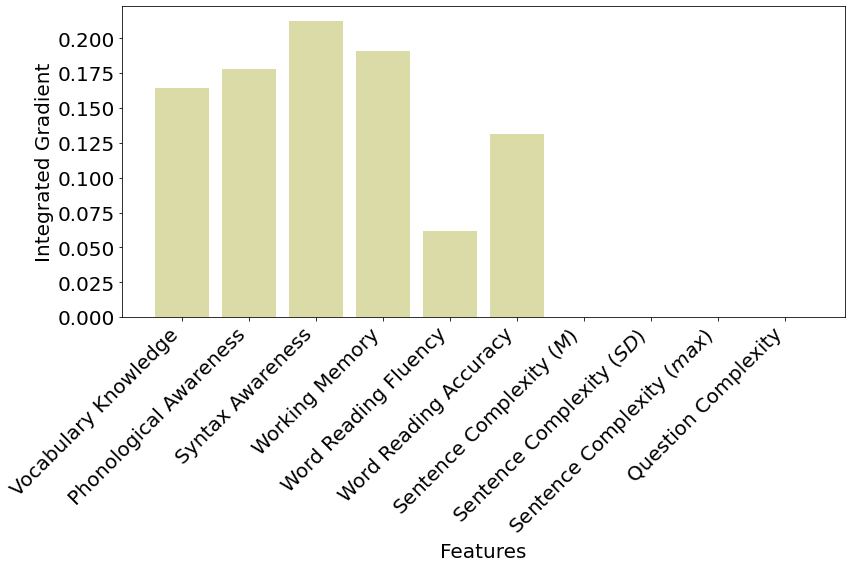

In [57]:
# visualize_importances(feature_names[:6], np.mean(attr, axis=0)[0,1,2,3,4,5,6,7,8,-1])
indices = [0,1,2,3,4,5,6,7,8,13]#[0,1,2,3,4,5,9,10,11]#[0,1,2,3,4,5,6,7,8,13]
title="Average Feature Importances"
plot=True
axis_title="Features"
new_f_names =[]
importances = np.mean(attr, axis=0)[indices]
for i,name in enumerate(feature_names):
    if i in indices:
        new_f_names.append(name)
        
for i in range(len(new_f_names)):
    print(new_f_names[i], ": ", '%.3f'%(importances[i]))
x_pos = (np.arange(len(new_f_names)))
if plot:
#     plt.figure(figsize=(12,6))
#     plt.bar(x_pos, importances, align='center')
#     plt.xticks(x_pos, new_f_names, rotation='vertical')
#     plt.xlabel(axis_title)
#     plt.ylim(-4.5,4.5)
#     plt.title(title)
    
    plt.figure(figsize=(12,8))
    plt.bar(x_pos, importances, align='center', color='#DBDBA7')
    plt.xticks(x_pos, new_f_names, rotation=45, ha="right", fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(axis_title,fontsize=20)
    plt.ylabel('Integrated Gradient', fontsize=20)
    # plt.ylim(-4.5,4.5)
    plt.tight_layout()
    


In [199]:
max_epochs = 300
ep_log_interval = 25
lrn_rate = 0.001
skill_dim = 11
verbose = False

model_results = []


for i in range(10):
    max_stats = [0,0,0,0,0] # each position represents acc, prec, recall, f1, epoch number respectively
    print(f"Run {i}")
    # Get training and testing data
    train_data, test_data = train_test_split(data, test_size=0.2, random_state = i)
    
    # fix layer initialization
    torch.manual_seed(i)
#     net = SimpleNet(skill_dim)
    net = SimpleNet_wr(skill_dim)
    criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
    train_ds = create_tensors(train_data)
    test_ds = create_tensors(test_data)

    
    for epoch in range(max_epochs):
        train_loss, train_acc = train_simple(net,train_ds,optimizer,criterion)

        if epoch % ep_log_interval == 0:
            
            valid_loss, valid_acc, prec, rec = evaluate_simple(net,test_ds,criterion,matrix=False)
            if verbose:
                print(f'Epoch: {epoch}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
                print('precision: ', prec)
                print('recall: ', rec)
                try:
                    f1 = 2*(prec*rec)/(prec+rec)
                    print(f"f1 = {f1}")
                except:
                    continue
            if valid_acc > max_stats[0]:
                max_stats[0] = float(valid_acc)
                max_stats[1] = prec
                max_stats[2] = rec
                max_stats[4] = epoch
                torch.save(net.state_dict(), 'sc_rw.pt')
                
    print(max_stats)        
    model_results.append(max_stats)




Run 0
[0.6618868112564087, 0.6625615763546798, 0.7556179775280899, 0, 250]
Run 1
[0.6815094351768494, 0.6807980049875312, 0.7668539325842697, 0, 275]
Run 2
[0.6807547211647034, 0.705655526992288, 0.7388963660834454, 0, 275]
Run 3
[0.6875471472740173, 0.699228791773779, 0.7513812154696132, 0, 200]
Run 4
[0.6769811511039734, 0.6832460732984293, 0.7372881355932204, 0, 275]
Run 5
[0.6830188632011414, 0.7031055900621118, 0.7576974564926372, 0, 225]
Run 6
[0.6747170090675354, 0.6825, 0.7551867219917012, 0, 250]
Run 7
[0.6867924332618713, 0.7146496815286624, 0.7460106382978723, 0, 275]
Run 8
[0.6762264370918274, 0.6933158584534731, 0.7306629834254144, 0, 250]
Run 9
[0.6800000071525574, 0.6878824969400245, 0.7688098495212038, 0, 250]


In [178]:
new_result = np.asarray(model_results)
print(new_result.shape)
print("mean",np.mean(new_result,axis=0))
print("std",np.std(new_result,axis=0))

(10, 5)
mean [  0.67403772   0.68092521   0.76501725   0.         237.5       ]
std [9.09707953e-03 1.55471808e-02 2.47110016e-02 0.00000000e+00
 4.77624329e+01]


In [109]:
new_result = np.asarray(model_results)
print(new_result.shape)
print("mean",np.mean(new_result,axis=0))
print("std",np.std(new_result,axis=0))

(10, 5)
mean [  0.67667924   0.68362236   0.76535506   0.         210.        ]
std [8.87362400e-03 1.20271144e-02 1.59176440e-02 0.00000000e+00
 4.21307489e+01]


## Error analysis

In [34]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state = 4)
test_ds = create_tensors(test_data)
model_2 = SimpleNet(6)
model_2.load_state_dict(torch.load('basemodel_full.pt'))
evaluate_simple(model_2,test_ds,criterion,matrix=False)


(tensor(0.7138), tensor(0.4657), 0.0, 0.0)

In [166]:
def McNemar_test(pred_1,pred_2,y):
    rounded_preds_1 = torch.round(torch.sigmoid(pred_1))
    correct_1 = rounded_preds_1 == y
    
    rounded_preds_2 = torch.round(torch.sigmoid(pred_2))
    correct_2 = rounded_preds_2 == y
    
    tl = 0
    tr = 0
    bl = 0
    br = 0
    
    a = []
    b = []
    c = []
    d = []
    
    for i in range(len(correct_1)):
        if correct_1[i] == 1 and correct_2[i] == 1:
            tl += 1
            a.append(i)
        elif correct_1[i] == 1 and correct_2[i] == 0:
            tr += 1
            b.append(i)
        elif correct_1[i] == 0 and correct_2[i] == 1:
            bl += 1
            c.append(i)
        elif correct_1[i] == 0 and correct_2[i] == 0:
            br += 1
            d.append(i)
        else:
            print('Unexpected value in counting correctness',correct_1[i],correct_2[i])
    
    t = PrettyTable(['', 'Model 2 Correct', 'Model 2 Wrong'])
    t.add_row(['Model 1 Correct', tl, tr])
    t.add_row(['Model 1 Wrong', bl, br])
    print(t)
    return tr,bl, [a,b,c,d]

In [230]:
from scipy.stats.distributions import chi2
# model_1 = SimpleNet_wr(7)
# model_1.load_state_dict(torch.load('vocab_rare.pt'))
# model_1 = SimpleNet(7)
# model_1.load_state_dict(torch.load('rare_word.pt'))
model_1 = BertModel1(64,7,0.2)
model_1.load_state_dict(torch.load('context_mean.pt'))
# model_1 = BertModel(64,7,0.2)
# model_1.load_state_dict(torch.load('sentence_embed.pt'))
# model_2 = SimpleNet_wr(11)
# model_2.load_state_dict(torch.load('sc_rw.pt'))
model_2 = BertModel2(64,7,0.2)
model_2.load_state_dict(torch.load('context_max.pt'))

with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)
train_data, test_data = train_test_split(data, test_size=0.2, random_state = 4)
test_ds = create_tensors(test_data)



model_1.eval()
model_2.eval()
pred_1 = model_1(test_ds['skills'],test_ds['subtests'],test_ds['questions']).squeeze(1)
# pred_1 = model_1(test_ds['skills']).squeeze(1)

# pred_2 = model_2(test_ds['skills']).squeeze(1)
pred_2 = model_2(test_ds['skills'],test_ds['subtests'],test_ds['questions']).squeeze(1)

b,c,index_table = McNemar_test(pred_1,pred_2,test_ds['y'])

chi_sq = (abs(b-c)-1)**2
chi_sq = chi_sq/(b+c)
print('McNemar test statistic:', chi_sq)

print('p-value:', chi2.sf(chi_sq, 1))

+-----------------+-----------------+---------------+
|                 | Model 2 Correct | Model 2 Wrong |
+-----------------+-----------------+---------------+
| Model 1 Correct |       891       |       25      |
|  Model 1 Wrong  |        14       |      395      |
+-----------------+-----------------+---------------+
McNemar test statistic: 2.5641025641025643
p-value: 0.10931457620866644


In [115]:
test_model = BertModel(64,14,0.1)
test_model.load_state_dict(torch.load('full.pt'))
with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)
train_data, test_data = train_test_split(data, test_size=0.2, random_state = 4)
test_ds = create_tensors(test_data)

test_model.eval()
test_pred = test_model(test_ds['skills'],test_ds['subtests'],test_ds['questions']).squeeze(1)
test_pred = torch.round(torch.sigmoid(test_pred))


In [216]:
print(test_ds['skills'][np.where(test_pred==test_ds['y'])[0],:][:,6].max())
print(test_ds['skills'][np.where(test_pred!=test_ds['y'])[0],:][:,6].max())
print(test_ds['skills'][np.where(test_pred==test_ds['y'])[0],:][:,8].max())
print(test_ds['skills'][np.where(test_pred!=test_ds['y'])[0],:][:,8].max())


tensor(10.3333)
tensor(10.3333)
tensor(16.)
tensor(16.)


In [131]:
print(len(np.where(test_pred!=1)[0]))
print(len(np.where(test_pred==1)[0]))

595
730


torch.Size([129, 14])
[0.45047352 0.6207752  0.51771885 0.45219633 0.46834636 0.73730624]
[0.17011869 0.21154872 0.17429112 0.16020443 0.14309908 0.08779691]


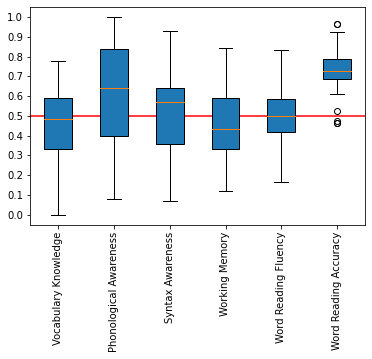

In [96]:
students_skills = test_ds['skills'][index_table[1]]
print(students_skills.shape)
pre_skills = students_skills[:,:6].numpy()
print(np.mean(pre_skills,axis=0))
print(np.std(pre_skills,axis=0))

# for i in range(6):
#     plt.boxplot(pre_skills[:,i])
plt.boxplot(pre_skills, vert=True, patch_artist=True, labels=feature_names[:6])
plt.xticks(rotation='vertical')
plt.yticks(np.arange(0,1.1,0.1))
plt.axhline(y=0.5, color='r', linestyle='-')
plt.show()

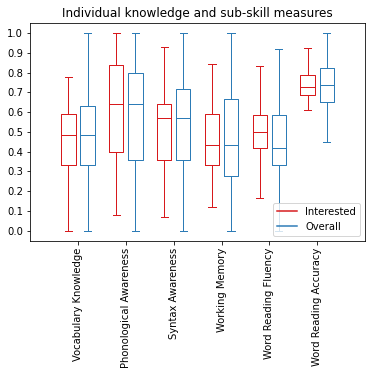

<Figure size 300x2000 with 0 Axes>

In [121]:
data_a = students_skills[:,:6].numpy()
data_b = test_ds['skills'][:,:6].numpy()

ticks = feature_names[:6]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(data_a.shape[1]))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(data_b.shape[1]))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Interested')
plt.plot([], c='#2C7BB6', label='Overall')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.xticks(rotation='vertical')
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Individual knowledge and sub-skill measures")
plt.figure(figsize=(3, 20),dpi = 100)

# plt.tight_layout()
# plt.savefig('boxcompare.png')
plt.show()

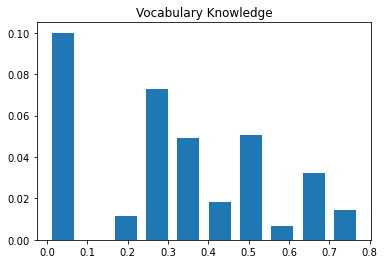

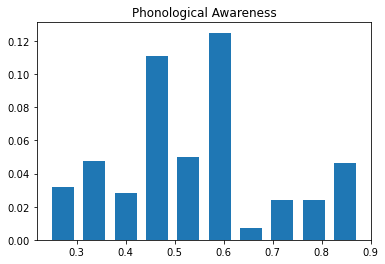

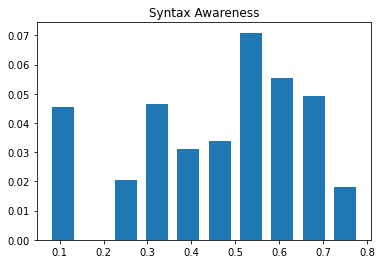

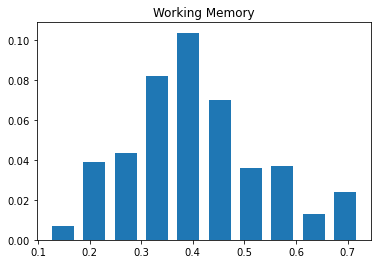

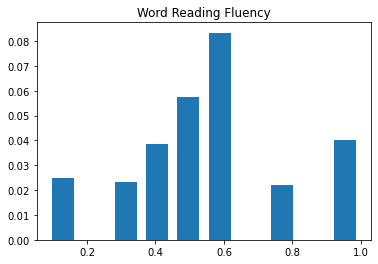

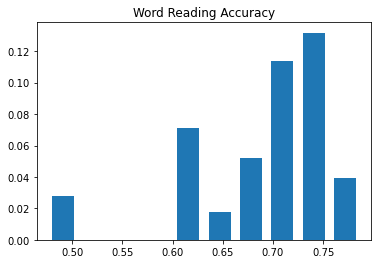

<ipython-input-143-4f97a6b31b97>:27: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(center, hist1/hist2, align='center', width=width)


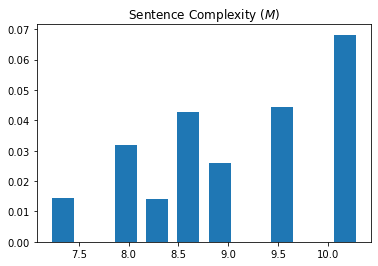

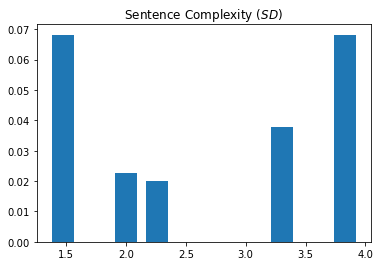

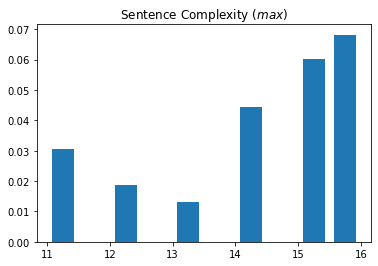

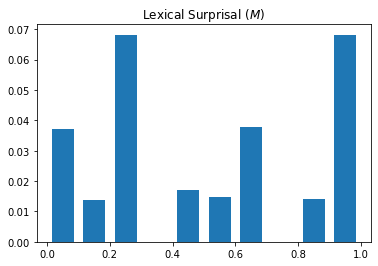

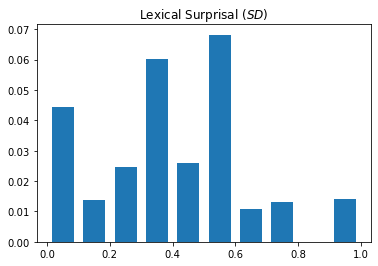

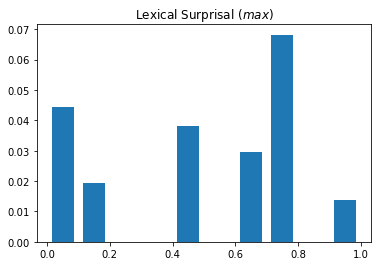

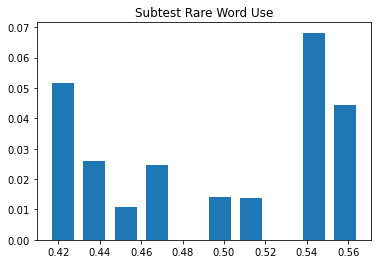

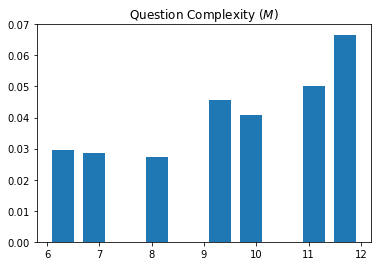

In [143]:
def get_distributions(index_list,dataset,feature_names):
    data_list = []
    dataset = np.asarray(dataset)
    for i in index_list:
        data_list.append(list(dataset[i]))
    data_list = np.asarray(data_list)
    
    for i in range(data_list.shape[1]):
        new_array = data_list[:,i]
#         print(new_array)
#         histo = np.histogram(new_array)
#         print(histo)
#         _ = plt.hist(new_array,range=(dataset[:,i].min(),dataset[:,i].max()))
#         plt.hist(new_array,range=(dataset[:,i].min(),dataset[:,i].max()))
#         plt.ylim(ymax = 350)
#         plt.title(feature_names[i]+ ' (Interested Entries)')
#         plt.show()
#         plt.hist(dataset[:,i],range=(dataset[:,i].min(),dataset[:,i].max()))
#         plt.ylim(ymax = 350)
        
        hist1,bins1 = np.histogram(new_array)

        width = 0.7 * (bins1[1] - bins1[0])
        center = (bins1[:-1] + bins1[1:]) / 2
        
        hist2,bins2 = np.histogram(dataset[:,i],bins = bins1)
        plt.bar(center, hist1/hist2, align='center', width=width)
        plt.title(feature_names[i])
        plt.show()

get_distributions(index_table[1],test_ds['skills'],feature_names)

In [11]:
with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)
train_data, test_data = train_test_split(data, test_size=0.2, random_state = 50)
test_ds = create_tensors(test_data)

In [147]:
# test_model = SimpleNet_wr(7)
# test_model.load_state_dict(torch.load('vocab_rare.pt'))
# model_2 = SimpleNet(6)
# model_2.load_state_dict(torch.load('basemodel.pt'))

# test_model = SimpleNet_surp(9)
# test_model.load_state_dict(torch.load('surprisal.pt'))

# model_1 = BertModel(64,14,0.2)
# model_1.load_state_dict(torch.load('full.pt'))
test_model = BertModel(64,14,0.2)
test_model.load_state_dict(torch.load('full.pt'))

test_model.eval()

pred_1 = test_model(test_ds['skills'],test_ds['subtests'],test_ds['questions']).squeeze(1)
# pred_1 = test_model(test_ds['skills']).squeeze(1)
y = test_ds['y']

rounded_preds_1 = torch.round(torch.sigmoid(pred_1))
correct_1 = rounded_preds_1 == y
err_index = []
for i in range(correct_1.shape[0]):
    if correct_1[i] == False:
        err_index.append(i)
print(correct_1.shape)
print(len(err_index))

torch.Size([1325])
412


0.0


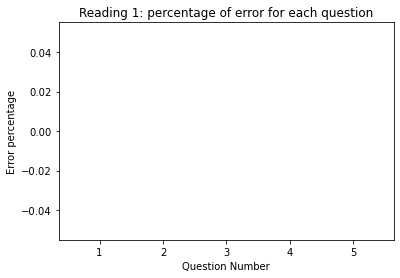

0.03571428571428571


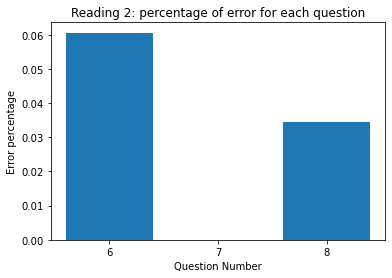

0.0


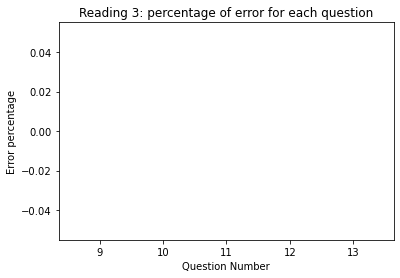

0.011111111111111112


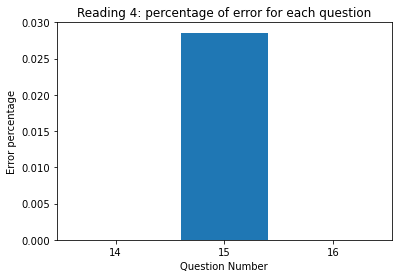

0.01652892561983471


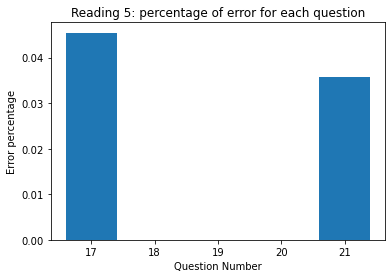

0.006329113924050633


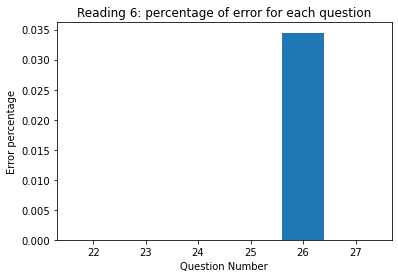

0.0


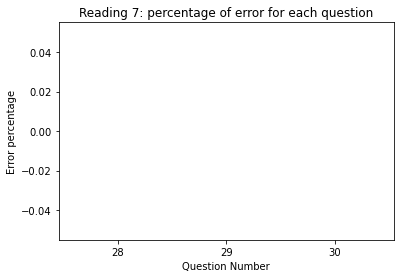

0.03816793893129771


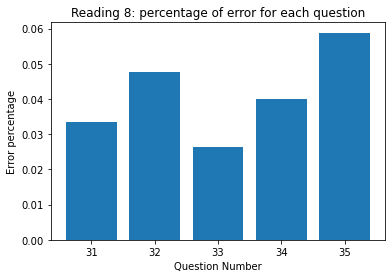

0.0072992700729927005


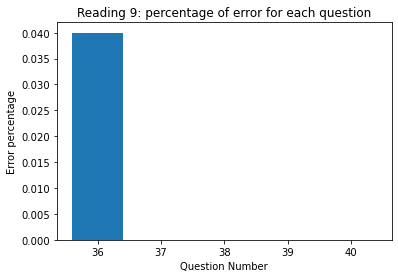

0.011111111111111112


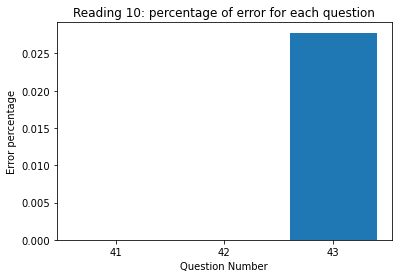

0.0


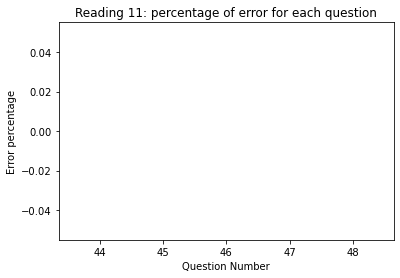

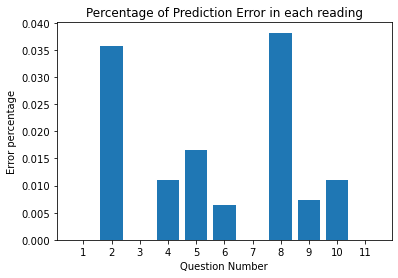

In [244]:
%matplotlib inline
def get_p_distrib(index_list,dataset):
    p_list = []
    dataset = np.asarray(dataset)
    for i in index_list:
        p_list.append(dataset[i])
    p_list = np.asarray(p_list)

#     plt.title('Text-wise Error distribution')
#     plt.xticks(np.arange(0, 10, step=1))
#     plt.show()
    return p_list
    
p_list = get_p_distrib(index_table[2],test_ds['p_index'])
p_overall = np.asarray(test_ds['p_index'])
counter1 = Counter(p_list[:,1])
counter2 = Counter(p_overall[:,1])


questions_ranges = [(1,5), (6,8), (9,13), (14,16), (17,21), (22,27), (28,30),
                   (31,35), (36,40), (41,43), (44,48)]

reading_num = []
reading_error_rate = []
for i in range(len(questions_ranges)):
    x = []
    y = []
    err_total = 0
    p_total = 0
    for j in range(questions_ranges[i][0],questions_ranges[i][1]+1):
        x.append(j)
        y.append(counter1[j]/counter2[j])
        err_total += counter1[j]
        p_total += counter2[j]
    
    print(err_total/p_total)
    reading_num.append(i+1)
    reading_error_rate.append(err_total/p_total)
    plt.bar(x,y)
    plt.title(f'Reading {i+1}: percentage of error for each question')
    plt.xlabel("Question Number")
    plt.ylabel("Error percentage")
    plt.xticks(x)
    plt.show()
    
plt.bar(reading_num,reading_error_rate)
plt.title('Percentage of Prediction Error in each reading')
plt.xlabel("Question Number")
plt.ylabel("Error percentage")
plt.xticks(reading_num)
plt.show()
    
# p_hist,bins = np.histogram(p_list[:,0],bins = 10)
# print(p_hist, bins)

# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# # print(p_hist/np.histogram(test_ds['p_index'])[0])
# plt.bar(center, p_hist/np.histogram(test_ds['p_index'],bins = 10)[0], align='center', width=width)
# plt.title("Percentage of Prediction Error in each reading")
# plt.ylabel('Percentage')
# plt.xlabel('Reading Number')
# # _ = plt.hist(test_ds['p_index'])

# # plt.title('Text-wise Error distribution')
# plt.xticks(np.arange(0, 10, step=1))
# plt.show()